<img align="left" hspace="100" alt="Coding" width="400" src="https://cdn.dribbble.com/users/247769/screenshots/6193788/media/ef684d0bf94d33a70251db49da02301e.gif">

<img align="right" alt="Coding" width="400" src="https://cdn.dribbble.com/users/954572/screenshots/16765270/media/9265ca52c0278b81ce7e656f8f3356ce.gif">



# Sentiment Analysis of Food rates on the Amazon site

###  Employing Sentiment analysis using 2 different techniques

#### 1. VADER (Valence Aware Dictionary and Sentiment Reasoner)
#### 2. Roberta pretrained Model
#### 3. Huggingface Pipeline

In [ ]:
!pip install kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d snap/amazon-fine-food-reviews

100% 242M/242M [00:01<00:00, 155MB/s]
100% 242M/242M [00:01<00:00, 156MB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [ ]:
!pip install patool

In [ ]:
import patoolib
patoolib.extract_archive('amazon-fine-food-reviews.zip')

patool: Extracting amazon-fine-food-reviews.zip ...
patool: running /usr/bin/7z x -o./Unpack_mq3x2ukh -- amazon-fine-food-reviews.zip
patool: ... amazon-fine-food-reviews.zip extracted to `amazon-fine-food-reviews' (multiple files in root).


'amazon-fine-food-reviews'

In [ ]:
df = pd.read_csv('amazon-fine-food-reviews/Reviews.csv')

In [ ]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
print(df.shape)

(568454, 10)


In [ ]:
df = df.head(2000)

## Quick EDA

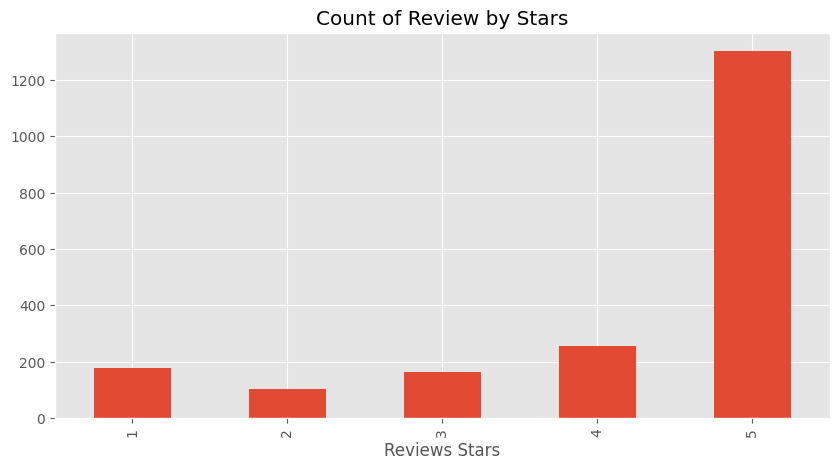

In [ ]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar',
                                            title='Count of Review by Stars',
                                            figsize=(10, 5))
ax.set_xlabel('Reviews Stars')
plt.show()

## Basic NLTK

In [ ]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [ ]:
nltk.download('punkt')                   # In case you face erroe uncomment these lines

tokens = nltk.word_tokenize(example)
tokens[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [ ]:
nltk.download('averaged_perceptron_tagger')   #uncomment if you face nltk lookup error
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.1 MB/s eta 0:00:00


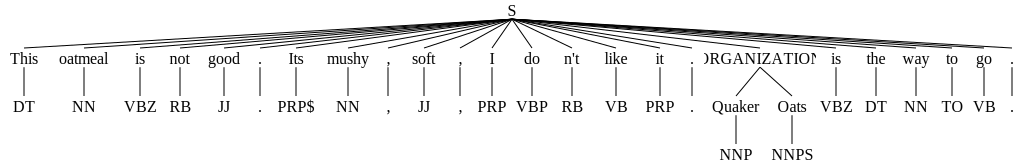

In [ ]:
nltk.download('maxent_ne_chunker')       #uncomment if you face problem
nltk.download('words')
!pip install svgling
nltk.chunk.ne_chunk(tagged)

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Sentiment Scoring

#### We will use NLTK's **SentimentIntensityAnalyzer** to get the neg/neu/pos scores of the text.

#### This use a "bag of words" approach:
> 1. Stop words are removed
> 2. Each word is scored and combined to a total score.

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()
sia

In [ ]:
sia.polarity_scores('I am so nervous!')

{'neg': 0.573, 'neu': 0.427, 'pos': 0.0, 'compound': -0.3989}

In [ ]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
# Run the polarity on the entire dataset

res = {}    #Dictionary for storing evering Id and its text polarity
for i, row in tqdm(df.iterrows(), total= len(df)):
  text = row['Text']
  myid = row['Id']
  res[myid] = sia.polarity_scores(text)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [ ]:
#Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER result

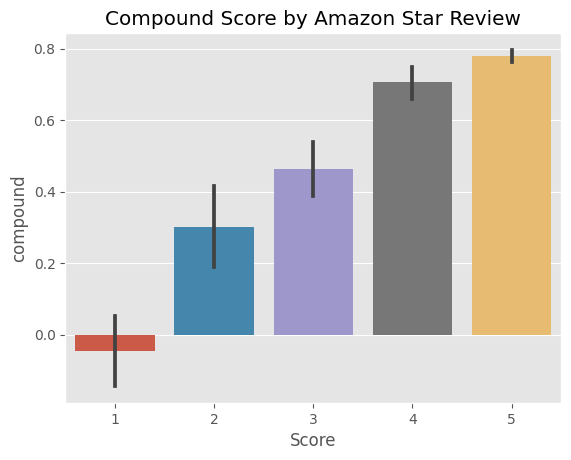

In [ ]:
ax = sns.barplot(data= vaders, x= 'Score', y= 'compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

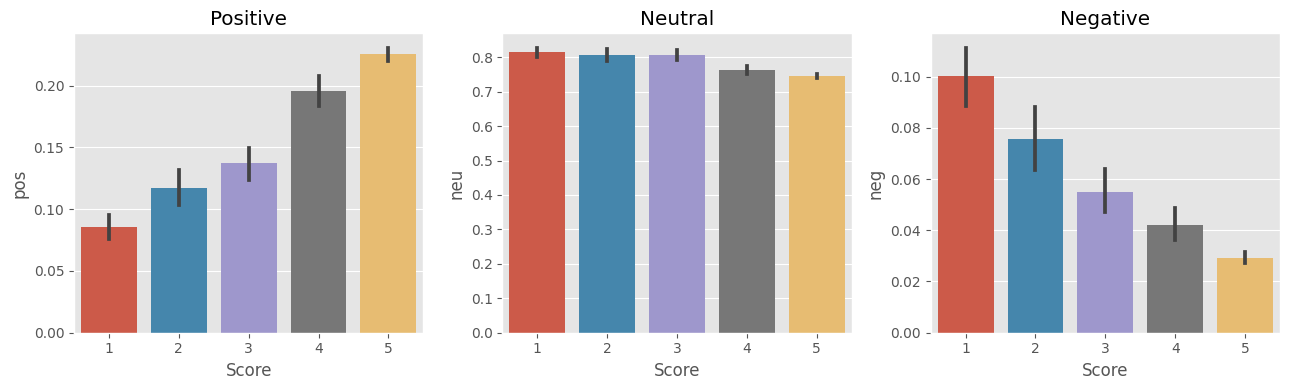

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
sns.barplot(data= vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data= vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data= vaders, x='Score', y='neg', ax=axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 2. Roberta Pretrained Model
> 1. Use a model trained of a large corpus of data
> 2. Transformer model accounts for the words but also the context related to other works

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# VADER result on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
#Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687476, 'roberta_pos': 0.002957372}


In [ ]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return scores_dict

In [ ]:
# Run the polarity on the entire dataset

res = {}    #Dictionary for storing evering Id and its text polarity
for i, row in tqdm(df.iterrows(), total= len(df)):
  try:
    text = row['Text']
    myid = row['Id']
    vadar_result = sia.polarity_scores(text)
    vadar_result_rename = {}
    for key, value in vadar_result.items():
      vadar_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(text)     #ignore the error because of big size of the text( model can't handel it)
    both = {**vadar_result, **roberta_result}
    res[myid] = both
  except RuntimeError:
    print(f'Broke for id {myid}')

  0%|          | 0/2000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1053
Broke for id 1070
Broke for id 1156
Broke for id 1321
Broke for id 1375
Broke for id 1498
Broke for id 1575
Broke for id 1796
Broke for id 1826


In [ ]:
result_df = pd.DataFrame(res).T
result_df = result_df .reset_index().rename(columns={'index': 'Id'})
result_df = result_df .merge(df, how='left')

In [ ]:
result_df.head()

,Id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Compare Scores between models

In [ ]:
result_df.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

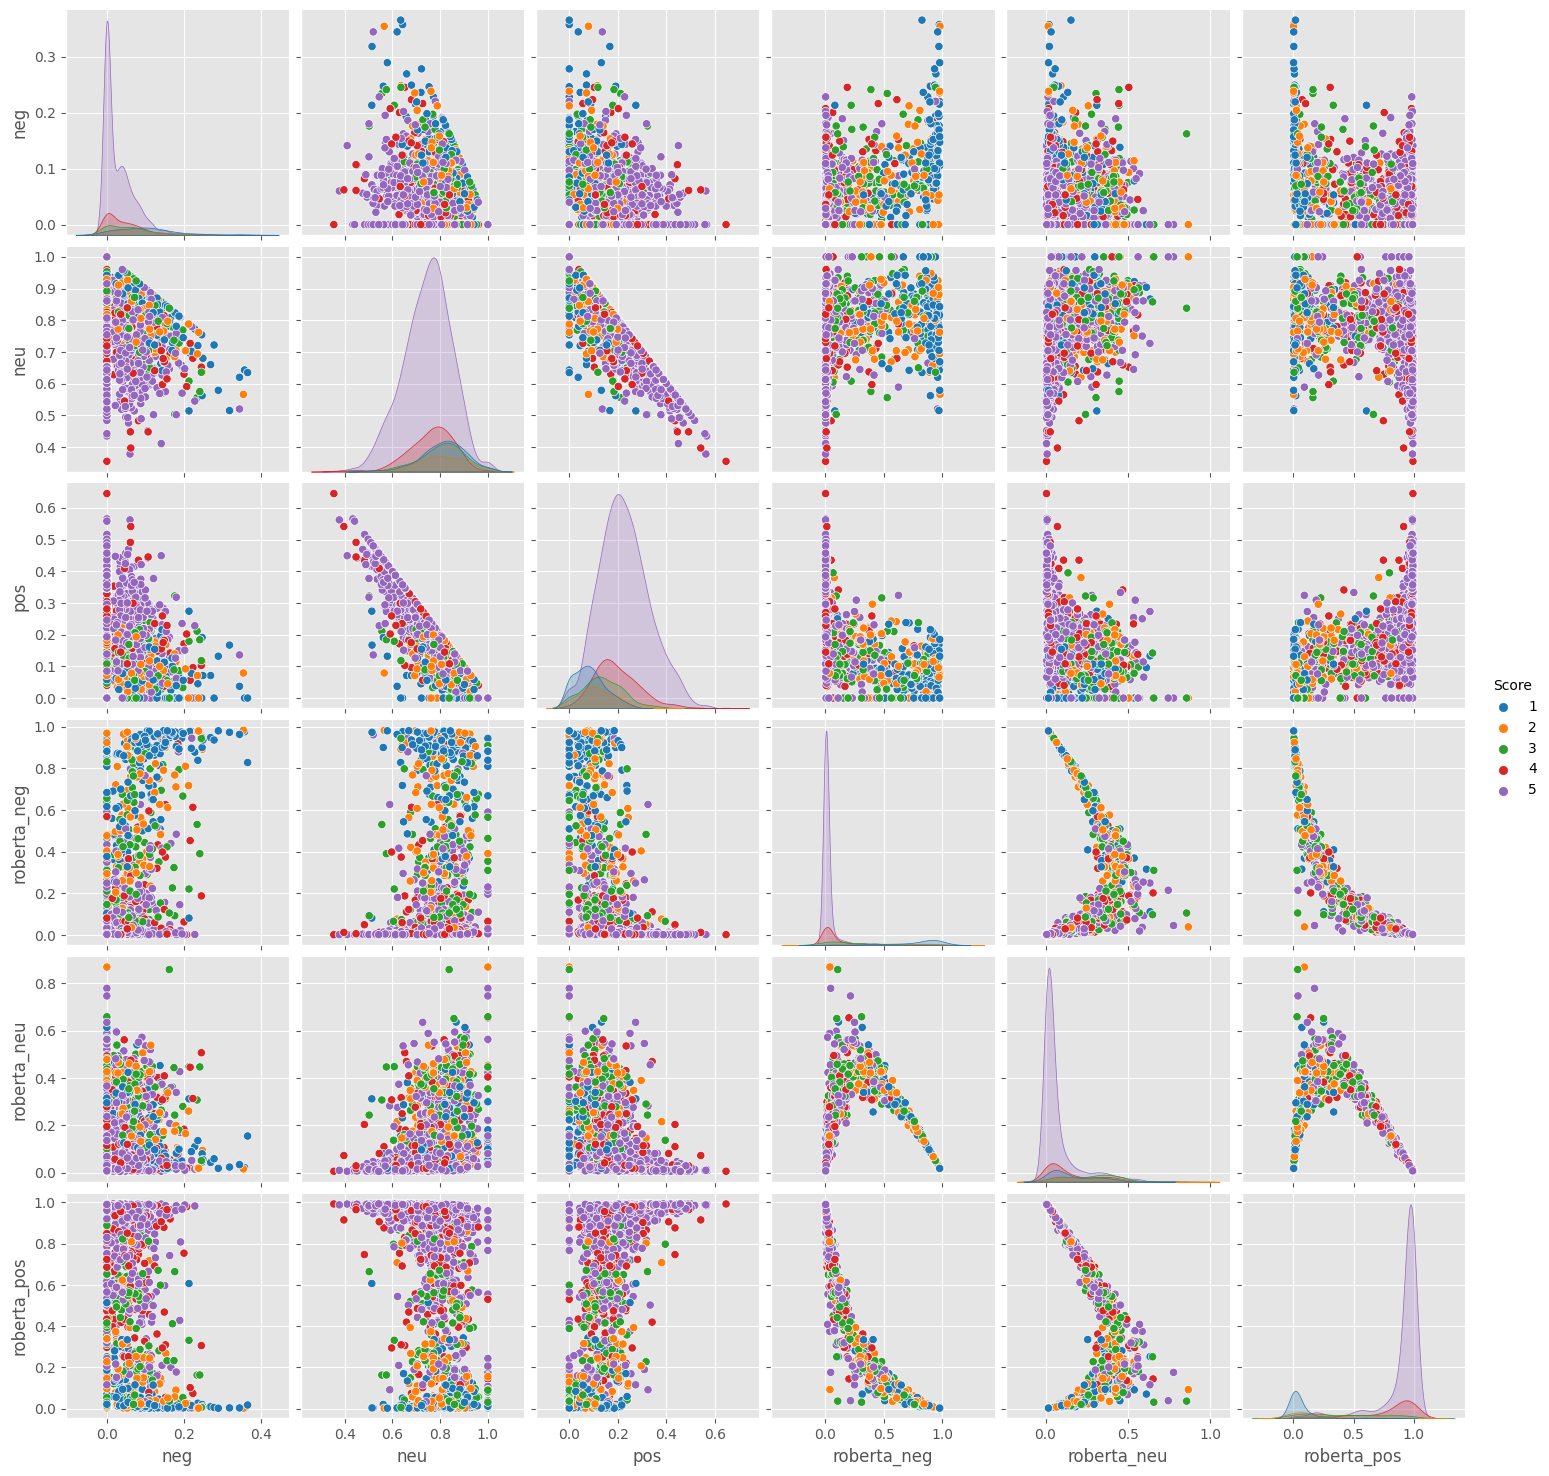

In [ ]:
sns.pairplot(data= result_df,
             vars=['neg', 'neu', 'pos',
                    'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue= 'Score',
             palette= 'tab10')
plt.show()

#### **Conclusion**: Based on result there are correlation between analysis even in **VADER** model, but it is less reliable compared to **Roberta** model which could seperate positive and negative emotions much better.

## Step 4: Review Examples:


*   Positive 1-Star and negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.




In [ ]:
#Reberta(model)_positive_sentence
result_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

"I just wanted to post here that I found small bits of plastic in this food as I was feeding my 9 month old.  Plastic!!! in food!!!! baby food!!!  So please be careful if you buy this or are considering it.<br /><br />My daughter LOVES this food-- it's actually her favorite.  This is the first time we have noticed plastic in it in over 2 months."

In [ ]:
#VADER(model)_negative_sentence
result_df.query('Score == 1').sort_values('pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [ ]:
#Robera(model)_negative_sentence
result_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [ ]:
#VADER(model)_negative_sentence
result_df.query('Score == 5').sort_values('neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Step 5: The transformers Pipeline

*   Quick and easy way to run sentiment predictions



In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
sent_pipeline('So we cancelled the order.  It was cancelled without any problem.  That is a positive note...')

[{'label': 'POSITIVE', 'score': 0.9988051652908325}]

In [ ]:
sent_pipeline('So, this is how you are on time, that is funny')

[{'label': 'POSITIVE', 'score': 0.999860405921936}]

# The End